In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os
load_dotenv()
PROJECT_ROOT = os.getenv('PROJECT_ROOT')

# Add PROJECT_ROOT to the Python path
import sys
sys.path.append(PROJECT_ROOT)

import numpy as np 
import networkx as nx

In [2]:
# Load the comprehensive route graph
import time 
time_start = time.time()
print('Reading navigation graph...')
G = nx.read_gml(os.path.join(PROJECT_ROOT, 'data', 'graphs', 'ats_fra_nodes_only.gml'))
print(f'Navigation graph loaded in {time.time() - time_start:.2f} seconds')
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')


Reading navigation graph...
Navigation graph loaded in 1.20 seconds
Number of nodes: 33763
Number of edges: 0


In [3]:
import pandas as pd
routes_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data', 'routes_data', 'cs_2023-04-01.csv'))
# column names: id	from_time	to_time	from_lat	from_lon	to_lat	to_lon	from_alt	to_alt	from_speed	to_speed
routes_df.head()

,id,from_time,to_time,from_lat,from_lon,to_lat,to_lon,from_alt,to_alt,from_speed,to_speed
0,000042HMJ225,1.680349e+09,1.680365e+09,42.941666,14.271751,46.177048,14.543554,11521.44,1569.72,0.232055,0.139918
1,000042HMJ225,1.680365e+09,1.680383e+09,46.177048,14.543554,35.847458,14.489973,1569.72,114.30,0.139918,0.000000
2,001260TC T124,1.680347e+09,1.680347e+09,40.781622,26.631546,40.737488,26.461792,4297.68,4876.80,0.031492,0.031096
3,001260TC T124,1.680347e+09,1.680348e+09,40.737488,26.461792,40.717529,26.377625,4876.80,5242.56,0.031096,0.029558
4,001260TC T124,1.680348e+09,1.680348e+09,40.717529,26.377625,40.729298,26.257761,5242.56,5486.40,0.029558,0.046496


In [4]:
flight_ids = routes_df['id'].unique()
print(f'There are {len(flight_ids)} unique flight ids in the routes data')
selected_flight_id = '0100A3MSR560'
print(f'Selected flight id: {selected_flight_id}')
selected_flight_df = routes_df[routes_df['id'] == selected_flight_id]
print(f'Selected flight df: {selected_flight_df.head()}')

There are 23947 unique flight ids in the routes data
Selected flight id: 0100A3MSR560
Selected flight df:               id     from_time       to_time   from_lat   from_lon     to_lat  \
56  0100A3MSR560  1.680319e+09  1.680319e+09  34.798822  27.681713  34.909570   
57  0100A3MSR560  1.680319e+09  1.680325e+09  34.909570  27.617397  45.970614   
58  0100A3MSR560  1.680325e+09  1.680329e+09  45.970614  18.859474  50.442444   
59  0100A3MSR560  1.680329e+09  1.680330e+09  50.442444  10.632019  50.968183   
60  0100A3MSR560  1.680330e+09  1.680330e+09  50.968183   8.138351  50.937040   

       to_lon  from_alt    to_alt  from_speed  to_speed  
56  27.617397  12306.30  12306.30    0.227358  0.225809  
57  18.859474  12306.30  12047.22    0.225809  0.235399  
58  10.632019  12047.22   9570.72    0.235399  0.235305  
59   8.138351   9570.72   2926.08    0.235305  0.160455  
60   7.379074   2926.08    967.74    0.160455  0.082072  


In [5]:
try:
    del GC
except:
    pass
# Add airports to the graph
from tqdm import tqdm
GC = G.copy()

In [6]:
from infer_route4 import process_flight_segments

final_route, new_nodes = process_flight_segments(GC, selected_flight_df, error_threshold=7.)

In [7]:
from infer_route4 import consolidate_nodes
final_route, new_nodes = consolidate_nodes(final_route, new_nodes)

In [8]:
final_route, new_nodes

([('_REj7gvbB', '_kgZHyDBr', 7.36581630112129),
  ('_kgZHyDBr', 'BABIT', 770.7071700690087),
  ('BABIT', 'PILAM', 425.40388735705415),
  ('PILAM', '_sLrZZlFE', 102.92695161172223),
  ('_sLrZZlFE', 'TANJO', 26.36114002485334),
  ('_Dz6zp8dI', '_J9oRGTDJ', 6.977869215813191),
  ('_J9oRGTDJ', 'EDDK', 2.9373898647274914)],
 {'_REj7gvbB': {'lat': 34.79882191803495, 'lon': 27.681713104248047},
  '_kgZHyDBr': {'lat': 34.9095696918035, 'lon': 27.61739730834961},
  '_sLrZZlFE': {'lat': 50.96818309719279, 'lon': 8.138351440429688},
  '_Dz6zp8dI': {'lat': 50.937039650092686, 'lon': 7.379074096679687},
  '_J9oRGTDJ': {'lat': 50.887042546676376, 'lon': 7.212677001953125}})

In [9]:
from infer_route4 import find_best_waypoint_for_data_capture

best_starting_point, best_starting_score = find_best_waypoint_for_data_capture(GC, (selected_flight_df.iloc[0]['from_lat'], selected_flight_df.iloc[0]['from_lon']), (selected_flight_df.iloc[0]['to_lat'], selected_flight_df.iloc[0]['to_lon']), prefer_endpoint='A')
print(f'Best starting point: {best_starting_point}, score: {best_starting_score}')

Best starting point: GUDIS, score: 16.346816492449896


In [10]:
# Add the waypoint to the final_route
ffinal_route = final_route.copy()
ffinal_route.insert(0, (best_starting_point, '__XXX__', 0))
print(ffinal_route)


[('GUDIS', '__XXX__', 0), ('_REj7gvbB', '_kgZHyDBr', 7.36581630112129), ('_kgZHyDBr', 'BABIT', 770.7071700690087), ('BABIT', 'PILAM', 425.40388735705415), ('PILAM', '_sLrZZlFE', 102.92695161172223), ('_sLrZZlFE', 'TANJO', 26.36114002485334), ('_Dz6zp8dI', '_J9oRGTDJ', 6.977869215813191), ('_J9oRGTDJ', 'EDDK', 2.9373898647274914)]


In [11]:
from infer_route4 import extract_real_waypoints

# Test the function with the final route
real_waypoints = extract_real_waypoints(ffinal_route, distance_threshold=20, skip_synthetic_waypoints=True)
real_full_waypoints = extract_real_waypoints(ffinal_route, distance_threshold=20, skip_synthetic_waypoints=False)
print("Real waypoints in the route:", real_waypoints)
print("Real full waypoints in the route:", real_full_waypoints)

Real waypoints in the route: ['GUDIS', 'BABIT', 'PILAM', 'TANJO', 'EDDK']
Real full waypoints in the route: ['GUDIS', '_kgZHyDBr', 'BABIT', 'PILAM', '_sLrZZlFE', 'TANJO', 'EDDK']


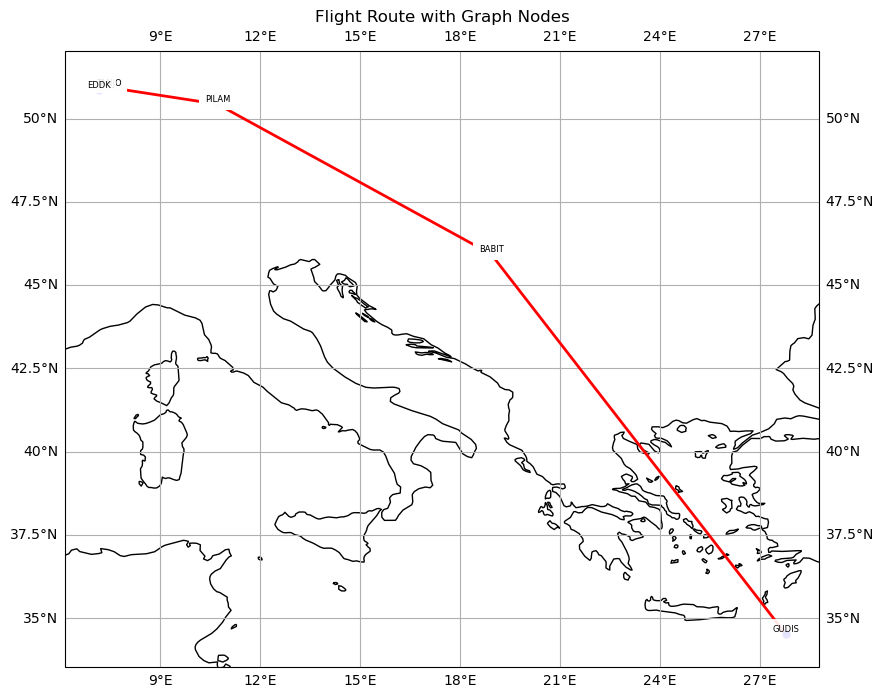

In [12]:
from utils.ploter import plot_route_with_graph_and_nodes_list_format
plot_route_with_graph_and_nodes_list_format(GC, real_waypoints, new_nodes)

# Batch Inference

In [18]:
from infer_route4 import find_route
from tqdm import tqdm

df_all_routes = pd.DataFrame(columns=['flight_id', 'real_waypoints', 'real_full_waypoints'])
df_synth_wps = pd.DataFrame(columns=['id', 'lat', 'lon'])

for flight_id in tqdm(flight_ids[:40]):
    selected_flight_df = routes_df[routes_df['id'] == flight_id]
    real_waypoints, real_full_waypoints, final_route, new_nodes = find_route(GC, selected_flight_df, error_threshold=15,
                                                                             distance_threshold_for_segment_skipping=20, max_wp_search_radius=12, min_wp_search_radius=2)
    df_all_routes = pd.concat([df_all_routes, pd.DataFrame({'flight_id': [flight_id],
                                                            'real_waypoints': ' '.join(real_waypoints),
                                                            'real_full_waypoints': ' '.join(real_full_waypoints),
                                                            })], ignore_index=True)
    # Add synthetic waypoints to df_synth_wps
    for node_id, node_data in new_nodes.items():
        df_synth_wps = pd.concat([df_synth_wps, pd.DataFrame({
            'id': [node_id],
            'lat': [node_data['lat']],
            'lon': [node_data['lon']]
        })], ignore_index=True)

  2%|▎         | 1/40 [00:00<00:09,  3.92it/s]/var/folders/r4/52yfj2854bl5v3zcbd28w4_r0000gn/T/ipykernel_18729/2097293392.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_synth_wps = pd.concat([df_synth_wps, pd.DataFrame({
100%|██████████| 40/40 [00:14<00:00,  2.83it/s]


In [19]:
df_all_routes.head(30)

,flight_id,real_waypoints,real_full_waypoints
0,000042HMJ225,INKIM LJLJ LMML MALTI,INKIM LJLJ LMML MALTI
1,001260TC T124,DRAMO LTFL,DRAMO LTFL
2,004E3CQVNDFU2,ULGIV OKUSE IBZEK,ULGIV OKUSE IBZEK
3,00B333N781DL,EDML EDQW LKRO XELET GODLO NAROX ROBEL TAMEB V...,EDML _ZMxdIkbi EDQW LKRO XELET _1g3C01CX _eM3T...
4,010092MSR741,LAKTO BIRES_29 EMEDA LCLK,LAKTO BIRES_29 EMEDA LCLK
5,010092MSR742,LCA SOBOS_91 LAKTO SISIM,LCA SOBOS_91 LAKTO SISIM
6,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,TANSA_98 METRU METRU_30 TOTTI LOTIN _XXwMWLnF ...
7,010092MSR832,ODGAX LUMED SALUN_66 METRU_30,ODGAX _uBn3fSvl _ap3Fdu3E LUMED SALUN_66 METRU_30
8,0100A3MSR560,GUDIS NIPIS BABIT PILAM TASWI TANJO EDDK,GUDIS NIPIS BABIT PILAM TASWI _aBQNqabY TANJO ...
9,0100A3MSR561,EDDK TANJO EDGB KAS_93 NIPIS GUDIS,EDDK TANJO _X8jTjjv6 EDGB KAS_93 NIPIS GUDIS


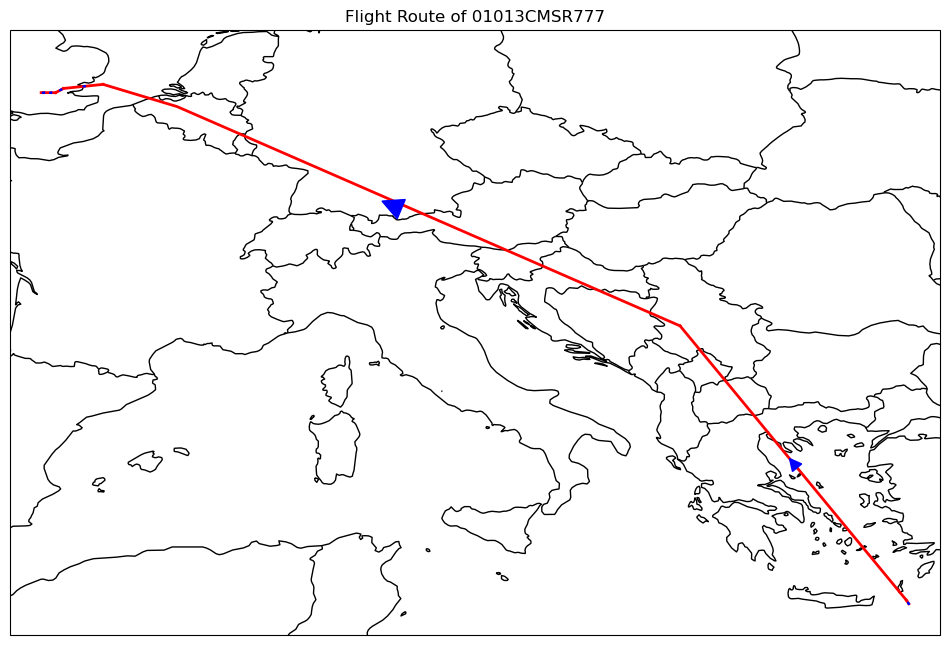

In [26]:
from utils.ploter import plot_route_of_flight
flight_id = '01013CMSR777'
plot_route_of_flight(routes_df[routes_df['id'] == flight_id])

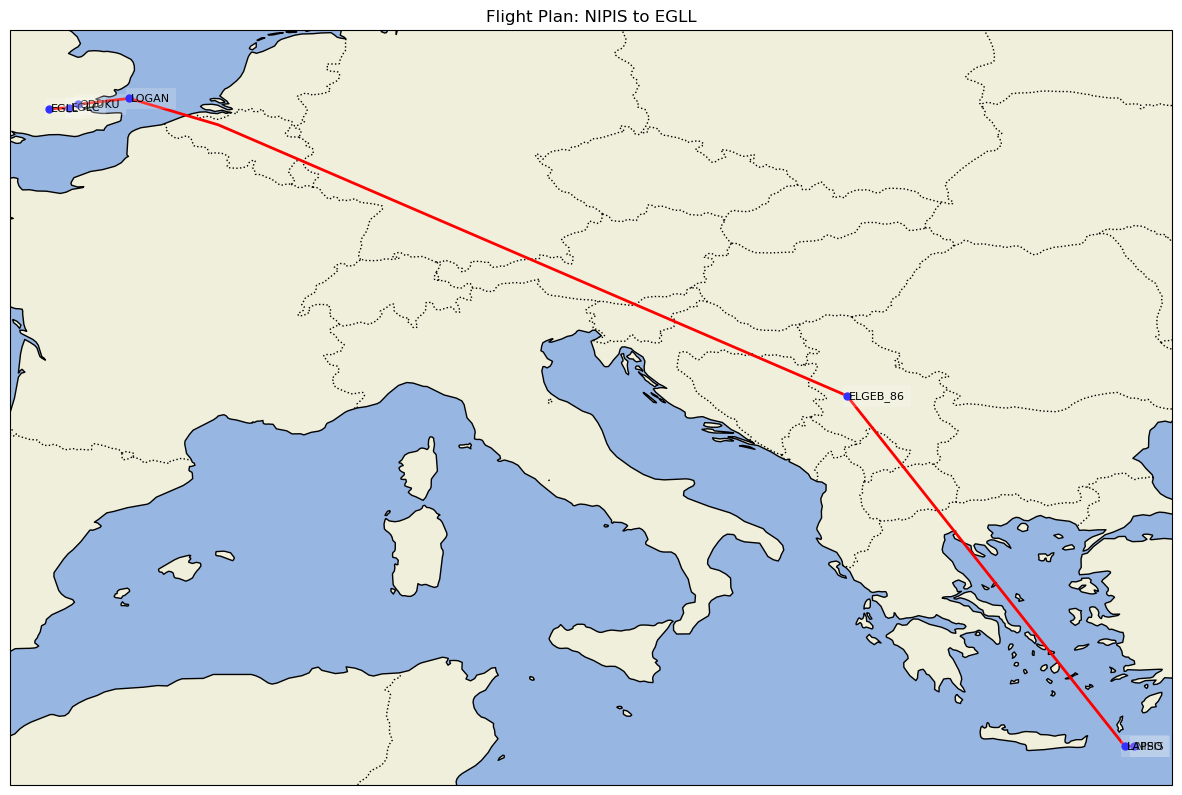

In [27]:
from utils.ploter import plot_flightplan2
plot_flightplan2(GC, df_all_routes[df_all_routes['flight_id'] == flight_id]['real_waypoints'].values[0].split(' '))

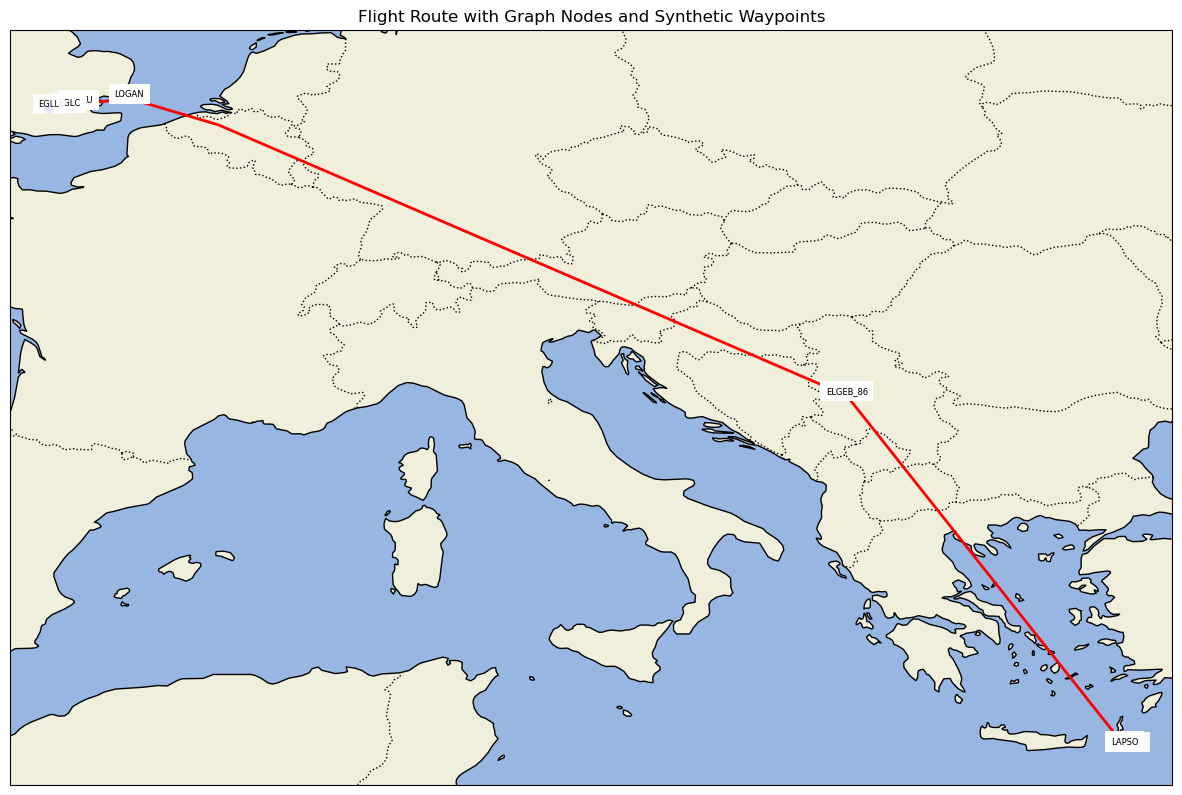

In [28]:
from utils.ploter import plot_route_with_graph_and_nodes_list_format_with_synth_wps
plot_route_with_graph_and_nodes_list_format_with_synth_wps(GC, df_all_routes[df_all_routes['flight_id'] == flight_id]['real_full_waypoints'].values[0], df_synth_wps)